In [53]:
#This notebook is to check all the data co-registrations are working and to plot the grids, etc. TLDR. It is fine.

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#For converting between geolocal and numerical ages
from pyrolite.util.time import Timescale

import scipy

import sys
sys.path.insert(1, '../pygplates_rev28_python37_win64')
import pygplates

import ptt

import glob
import os

import seaborn as sns

import cartopy.crs as ccrs

In [54]:
def read_netcdf_grid(filename, return_grids=False, resample=None):
    """
    Read in a netCDF file and re-align from -180 to 180 degrees
    
    Parameters
    ----------
    filename : str
        path to netCDF file
    return_grids : bool
        optionally return lon, lat arrays associated with grid
    resample : tuple
        optionally resample grid, pass spacing in X and Y direction as a tuple
        e.g. resample=(spacingX, spacingY)
    """
    import netCDF4
    from scipy.interpolate import RegularGridInterpolator
    
    # open netCDF file and re-align from -180, 180 degrees
    with netCDF4.Dataset(filename, 'r') as cdf:
        cdf_grid = cdf["z"]
        try:
            cdf_lon = cdf['lon'][:]
            cdf_lat = cdf['lat'][:]
        except:
            cdf_lon = cdf['x'][:]
            cdf_lat = cdf['y'][:]
            
        cdf_lon_mask = cdf_lon[:] > 180
        
        if cdf_lon_mask.any():
            cdf_grid_z = np.hstack([cdf_grid[:,cdf_lon_mask], cdf_grid[:,~cdf_lon_mask]])
            cdf_lon = np.hstack([cdf_lon[cdf_lon_mask], cdf_lon[~cdf_lon_mask]])
        else:
            cdf_grid_z = cdf_grid[:]

    # resample
    if resample is not None:
        spacingX, spacingY = resample
        lon_grid = np.arange(cdf_lon.min(), cdf_lon.max()+spacingX, spacingX)
        lat_grid = np.arange(cdf_lat.min(), cdf_lat.max()+spacingY, spacingY)
        lonq, latq = np.meshgrid(lon_grid, lat_grid)
        interp = RegularGridInterpolator((cdf_lat, cdf_lon), cdf_grid_z, method='nearest', bounds_error=False)
        cdf_grid_z = interp((latq, lonq))
        cdf_lon = lon_grid
        cdf_lat = lat_grid
            
    if return_grids:
        return cdf_grid_z, cdf_lon, cdf_lat
    else:
        return cdf_grid_z
    
    
def fill_ndimage(data,invalid=None):
    """
    Replace the value of invalid 'data' cells (indicated by 'invalid')
    by the value of the nearest valid data cell
    """
    from scipy.ndimage import distance_transform_edt
    masked_array = hasattr(data, "fill_value")
    if masked_array:
        mask_fill_value = data.data == data.fill_value
        data = data.data.copy()
        data[mask_fill_value] = np.nan
    else:
        data = data.copy()

    if invalid is None:
        invalid = np.isnan(data)
        if masked_array:
            invalid += mask_fill_value
    ind = distance_transform_edt(invalid, return_distances=False, return_indices=True)
    return data[tuple(ind)]

In [55]:
df=pd.read_csv("petlab_withgrids.csv")
df.replace(to_replace=0.0, value=np.nan, inplace=True)
sigvars=['ReconLon','ReconLat','ReconAge',
         'gridage', 'gridcrust', 'gridsubcrust', 'gridlith', 'gridsublith', 'gridsed', 'gridsubsed', 'gridsubserp',
        'gridslabtop','gridslabage','gridslabdip','gridslabthick','gridslabvel','gridslabsubage']
dfsub=df[sigvars].copy()
dfsub

ReconLon   ReconLat  ReconAge     gridage  gridcrust  gridsubcrust  \
0    177.937800 -29.257800       NaN   27.324570   0.000006           NaN   
1    167.174994 -46.714965       1.0  105.385642   0.000009      0.000067   
2    179.033010 -31.237992       1.0   27.209710   0.000006      0.000020   
3    176.269419 -37.569659       1.0   93.313096   0.000008      0.000019   
4    176.269419 -37.569659       1.0   93.313096   0.000008      0.000019   
..          ...        ...       ...         ...        ...           ...   
967  149.731059 -60.921505     270.0         NaN        NaN           NaN   
968  141.250045 -40.607639     285.0         NaN        NaN           NaN   
969  149.756105 -66.253986     324.0         NaN        NaN           NaN   
970  146.982800 -57.928381     356.0         NaN        NaN           NaN   
971  138.826891 -43.182322     381.0         NaN        NaN           NaN   

     gridlith  gridsublith   gridsed  gridsubsed  gridsubserp  gridslabtop  \
0    0.000004          NaN  0.000046         NaN          NaN   554.976000   
1    0.000004     0.000040  0.000006    0.000038     0.000593   211.261357   
2    0.000004     0.000009  0.000045    0.000006     0.000004   457.352965   
3    0.000004     0.000013  0.000121    0.000050     0.000002   156.997191   
4    0.000004     0.000013  0.000121    0.000050     0.000002   156.997191   
..        ...          ...       ...         ...          ...          ...   
967       NaN          NaN       NaN         NaN          NaN          NaN   
968       NaN          NaN       NaN         NaN          NaN          NaN   
969       NaN          NaN       NaN         NaN          NaN          NaN   
970       NaN          NaN       NaN         NaN          NaN          NaN   
971       NaN          NaN       NaN         NaN          NaN          NaN   

     gridslabage  gridslabdip  gridslabthick  gridslabvel  gridslabsubage  
0            NaN          NaN            NaN          NaN       26.414402  
1      34.427736    22.125766  199237.799460     0.001547       26.285441  
2      11.328286     6.403112   16727.324381     0.014635       23.292555  
3            NaN          NaN            NaN          NaN       39.052911  
4            NaN          NaN            NaN          NaN       39.052911  
..           ...          ...            ...          ...             ...  
967          NaN          NaN            NaN          NaN             NaN  
968          NaN          NaN            NaN          NaN             NaN  
969          NaN          NaN            NaN          NaN             NaN  
970          NaN          NaN            NaN          NaN             NaN  
971          NaN          NaN            NaN          NaN             NaN  

[972 rows x 17 columns]

In [56]:
dfneg=pd.read_csv("petlab_withgrids_neg_loc1.csv")
dfneg.replace(to_replace=0.0, value=np.nan, inplace=True)
sigvars=['ReconLon','ReconLat','ReconAge',
         'gridage', 'gridcrust', 'gridsubcrust', 'gridlith', 'gridsublith', 'gridsed', 'gridsubsed', 'gridsubserp',
        'gridslabtop','gridslabage','gridslabdip','gridslabthick','gridslabvel','gridslabsubage']
dfsubneg=dfneg[sigvars].copy()
dfsubneg

ReconLon   ReconLat  ReconAge     gridage  gridcrust  gridsubcrust  \
0    170.026587 -39.746810       NaN  108.750618   0.000009      0.000020   
1    175.212068 -20.411373       1.0    3.392563   0.000003      0.000013   
2    173.173887 -17.149532       1.0    4.333398   0.000003      0.000014   
3    170.394295 -40.790936       1.0  108.439812   0.000009      0.000025   
4    157.570550 -49.063048       1.0   44.879246   0.000008      0.000019   
..          ...        ...       ...         ...        ...           ...   
967  175.147734 -14.779146     270.0         NaN        NaN           NaN   
968  154.275820 -59.185269     285.0         NaN        NaN           NaN   
969  169.195186 -17.784054     324.0         NaN        NaN           NaN   
970  144.306828 -58.944469     356.0         NaN        NaN           NaN   
971  173.751770 -30.726939     381.0         NaN        NaN           NaN   

     gridlith  gridsublith   gridsed  gridsubsed  gridsubserp  gridslabtop  \
0    0.000004     0.000012  0.000002    0.000005     0.000012  1229.872411   
1    0.000004     0.000008  0.000005    0.000037     0.000002   456.992802   
2    0.000004     0.000008  0.000008    0.000036     0.000003   450.000000   
3    0.000004     0.000015  0.000006    0.000008     0.000012   285.771795   
4    0.000006     0.000009  0.000027    0.000015          NaN  1590.000000   
..        ...          ...       ...         ...          ...          ...   
967       NaN          NaN       NaN         NaN          NaN          NaN   
968       NaN          NaN       NaN         NaN          NaN          NaN   
969       NaN          NaN       NaN         NaN          NaN          NaN   
970       NaN          NaN       NaN         NaN          NaN          NaN   
971       NaN          NaN       NaN         NaN          NaN          NaN   

     gridslabage  gridslabdip  gridslabthick  gridslabvel  gridslabsubage  
0       4.954582     3.839957   10320.064933     0.006363       61.344216  
1      13.728686    38.356535   45850.041146     0.193568       26.813780  
2            NaN          NaN            NaN          NaN       24.405747  
3      36.007373    27.855411   75209.716756     0.045210       51.300157  
4      12.057608    14.271761   28489.016359     0.040083       95.035261  
..           ...          ...            ...          ...             ...  
967          NaN          NaN            NaN          NaN             NaN  
968          NaN          NaN            NaN          NaN             NaN  
969          NaN          NaN            NaN          NaN             NaN  
970          NaN          NaN            NaN          NaN             NaN  
971          NaN          NaN            NaN          NaN             NaN  

[972 rows x 17 columns]

In [57]:
#Group the samples by age (i.e by grid file) for efficency
groups=dfsub.groupby("ReconAge")
groupsneg=dfsubneg.groupby("ReconAge")

In [58]:
#Set the file names of each of the grids
agegrid_filename = "../Data/M2020_AgeGrids/Muller_etal_2019_Tectonics_v2.0_AgeGrid-{:.0f}.nc"
carcrust_filename = "../Data/Crust/carbon_crust_grid_{:.0f}.nc"
subcarcrust_filename = "../Data/Crust/subducted_carbon_crust_{:.0f}.nc"
carlith_filename = "../Data/Lithosphere/carbon_lithosphere_grid_{:.0f}.nc"
subcarlith_filename = "../Data/Lithosphere/subducted_carbon_lithosphere_{:.0f}.nc"
carsed_filename = "../Data/Sediment/carbon_sediment_grid_{:.0f}.nc"
subcarsed_filename ="../Data/Sediment/subducted_carbon_sediment_{:.0f}.nc"
carserp_filename = "../Data/Serpentinite/carbon_serpentinite_grid_{:.0f}.nc"
subcarserp_filename = "../Data/Serpentinite/subducted_carbon_serpentinite_{:.0f}.nc"
#sed_filename = "../Data/decompacted_carbonate_sediment_thickness/decompacted_carbonate_sediment_thickness_mean/decompacted_sediment_thickness_0.5_{:.0f}.nc"

slabtop_filename = "../Data/slab_tops.nc" #Think about how this gets coregistered to each point's birth position
slabage_filename = "../Data/cumulative_slab_age_grid.nc" 
slabdip_filename = "../Data/cumulative_slab_dip_grid.nc"
slabthick_filename = "../Data/cumulative_slab_thickness_grid.nc"
slabvel_filename = "../Data/cumulative_slab_vel_grid.nc"
slabsubage_filename = "../Data/cumulative_subduction_age.nc"

extent_globe = [-180, 180, -90, 90]

In [59]:
sigvars

['ReconLon',
 'ReconLat',
 'ReconAge',
 'gridage',
 'gridcrust',
 'gridsubcrust',
 'gridlith',
 'gridsublith',
 'gridsed',
 'gridsubsed',
 'gridsubserp',
 'gridslabtop',
 'gridslabage',
 'gridslabdip',
 'gridslabthick',
 'gridslabvel',
 'gridslabsubage']

1.0


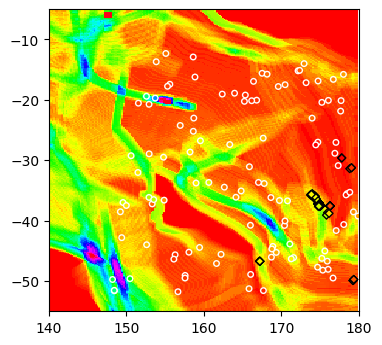

2.0


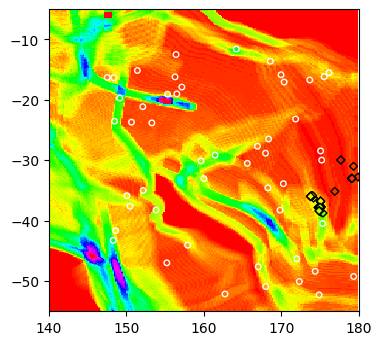

3.0


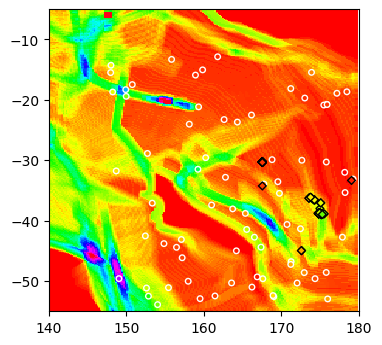

4.0


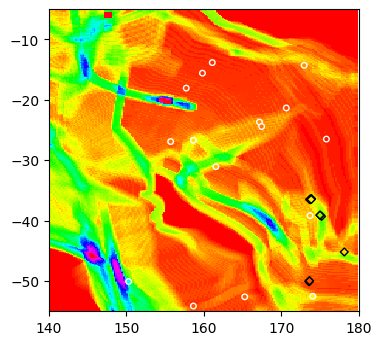

5.0


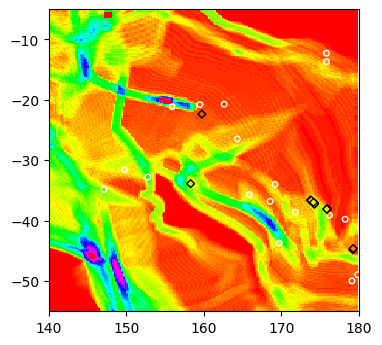

6.0


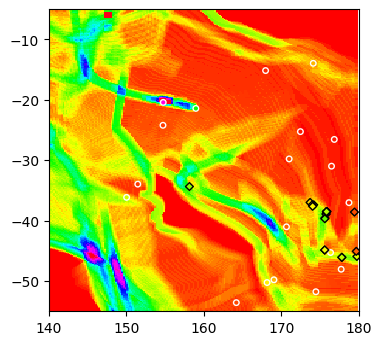

7.0


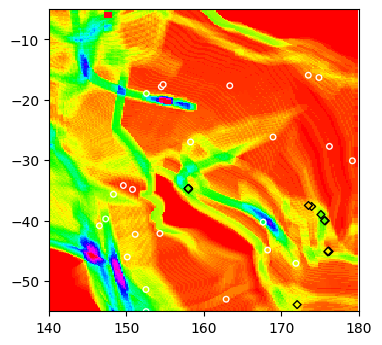

8.0


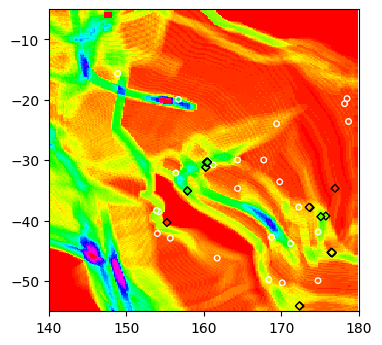

9.0


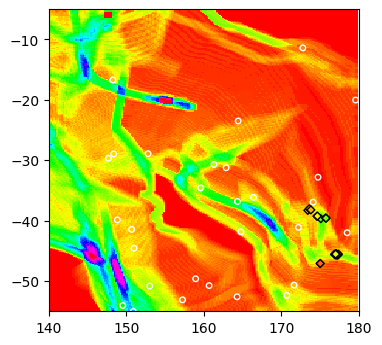

10.0


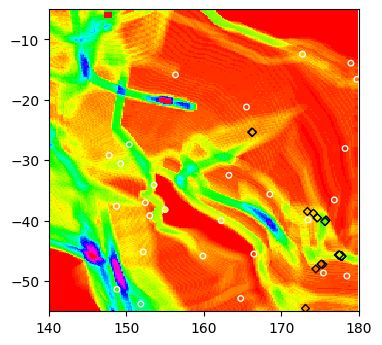

11.0


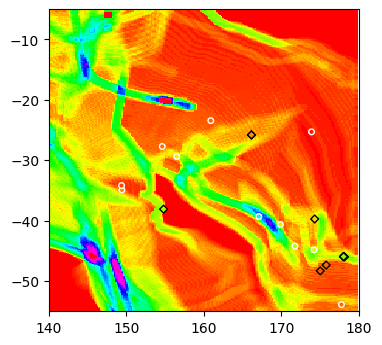

12.0


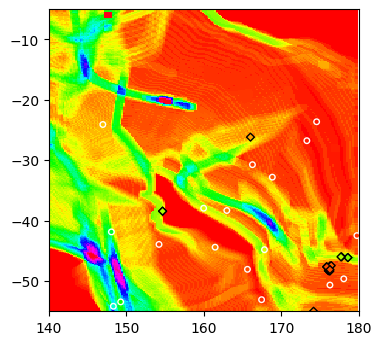

13.0


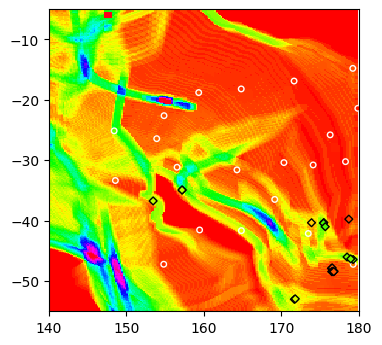

14.0


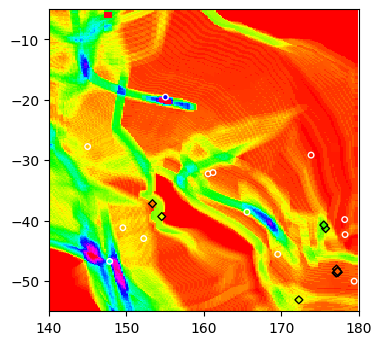

15.0


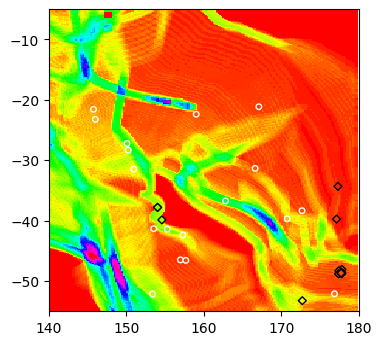

16.0


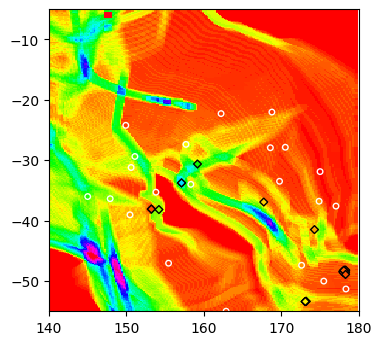

17.0


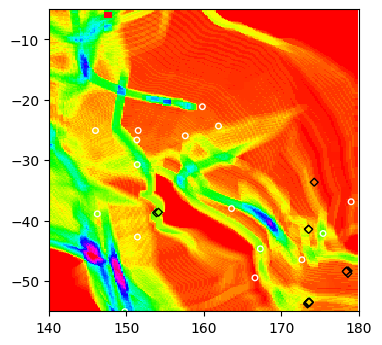

18.0


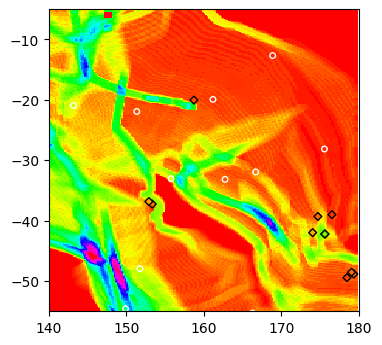

19.0


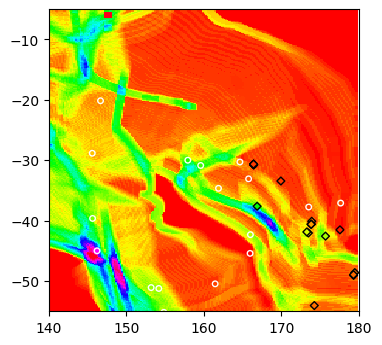

20.0


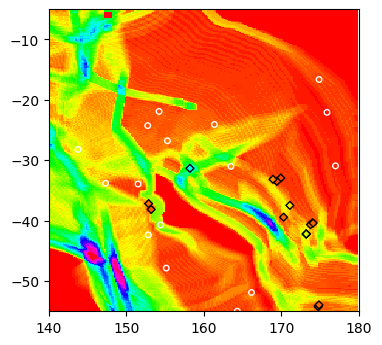

21.0


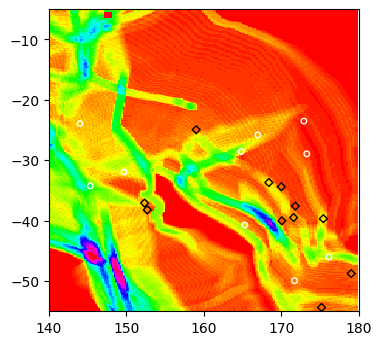

22.0


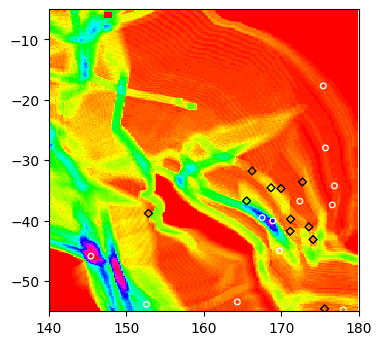

23.0


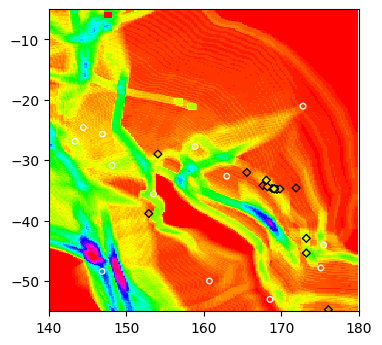

24.0


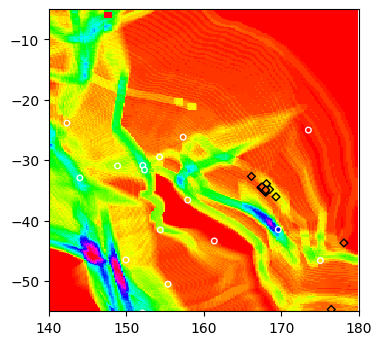

25.0


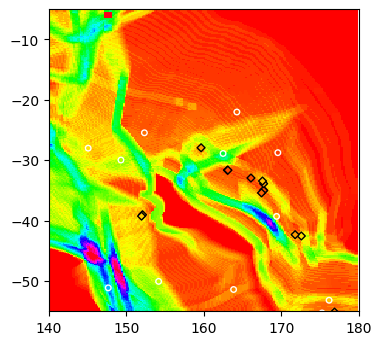

26.0


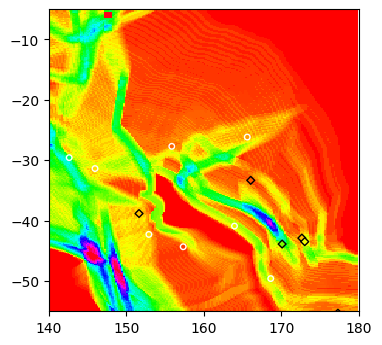

27.0


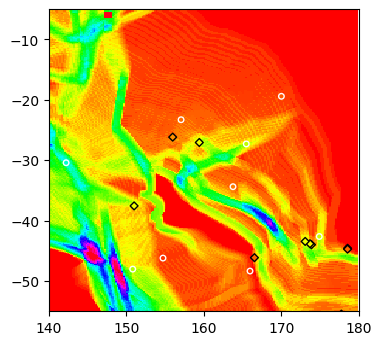

28.0


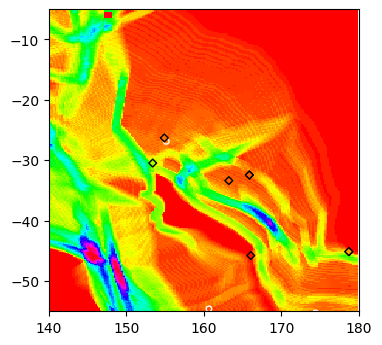

29.0


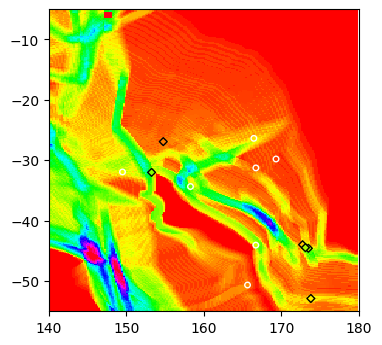

30.0


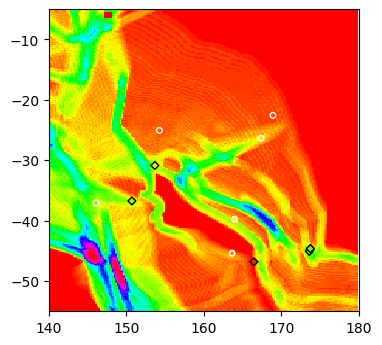

31.0


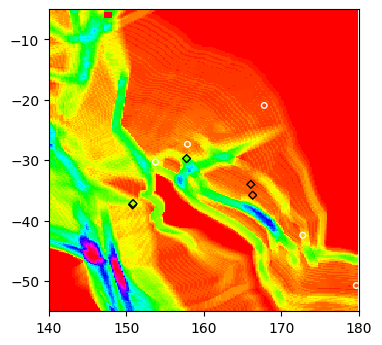

32.0


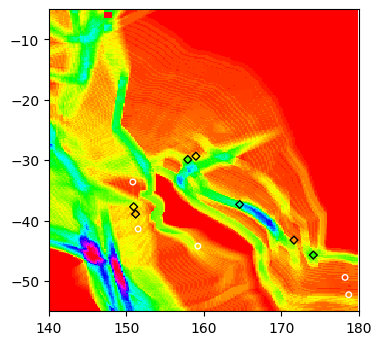

33.0


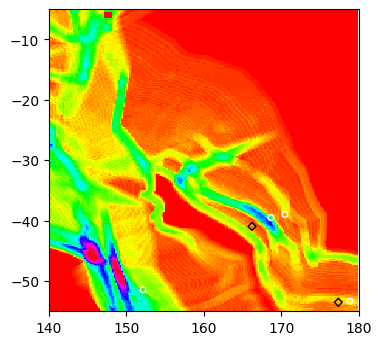

34.0


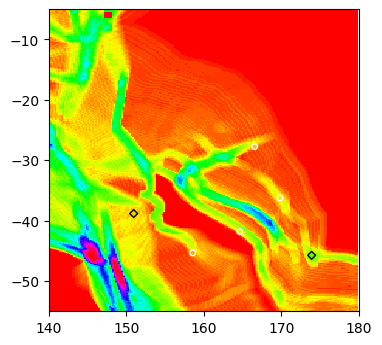

35.0


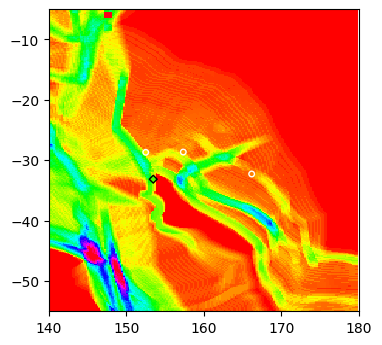

36.0


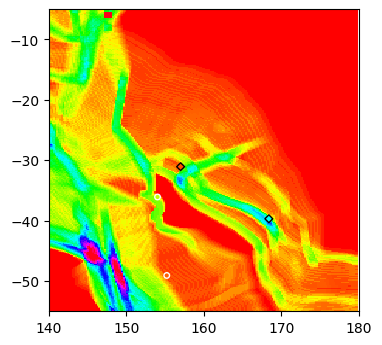

37.0


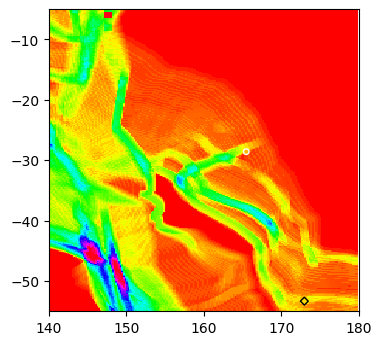

38.0


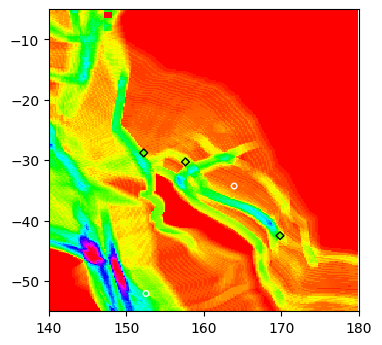

39.0


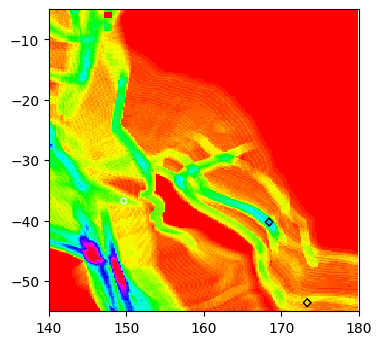

40.0


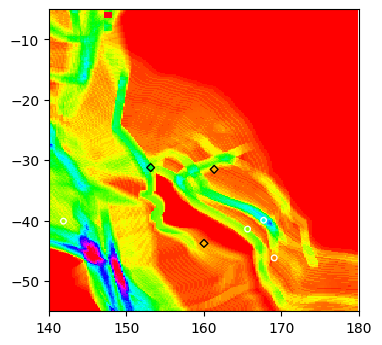

41.0


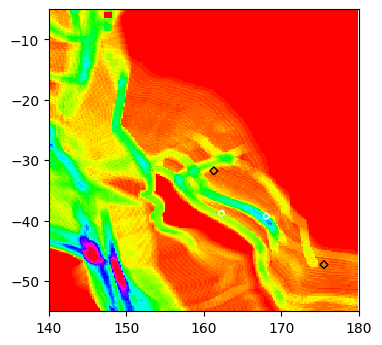

42.0


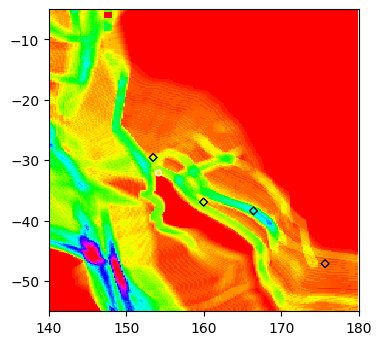

44.0


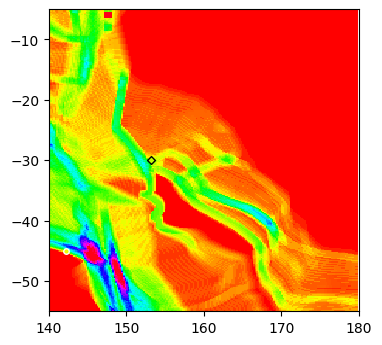

46.0


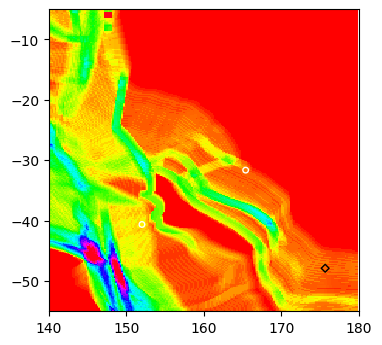

47.0


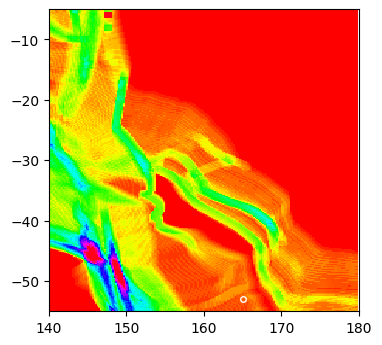

48.0


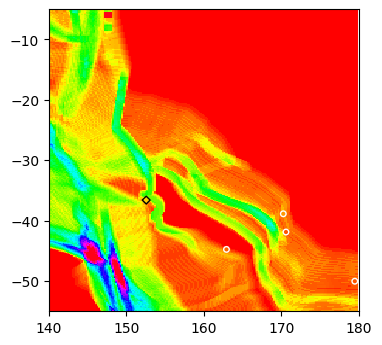

49.0


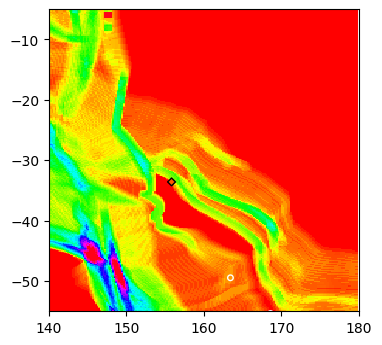

50.0


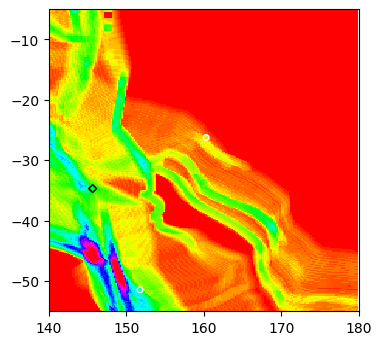

51.0


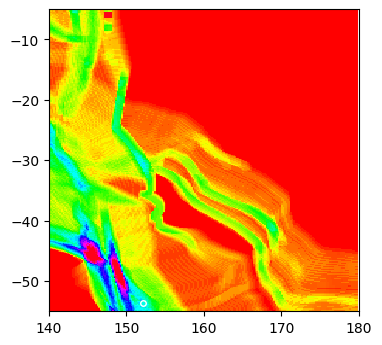

52.0


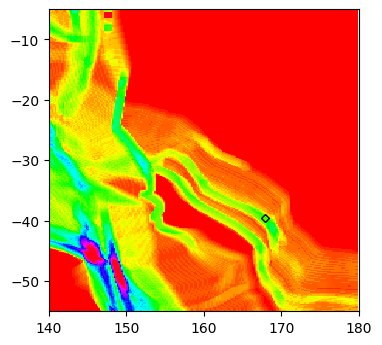

53.0


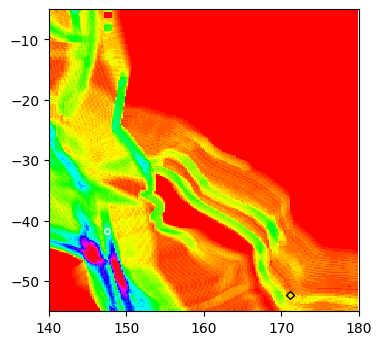

55.0


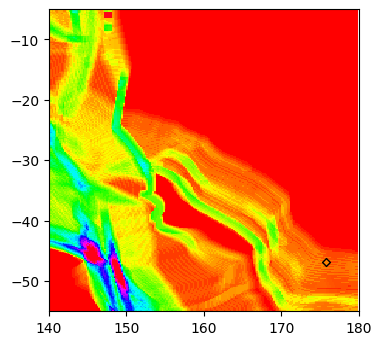

57.0


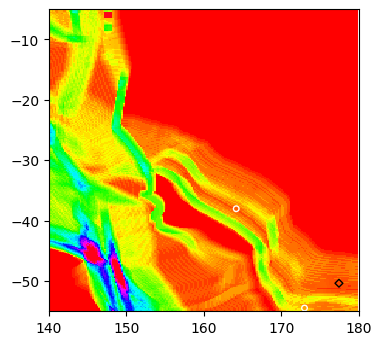

58.0


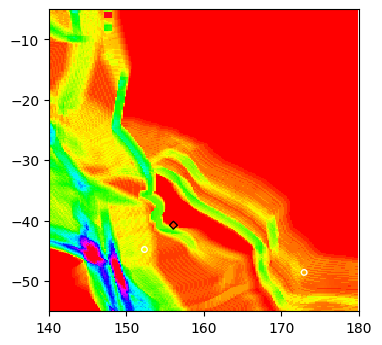

59.0


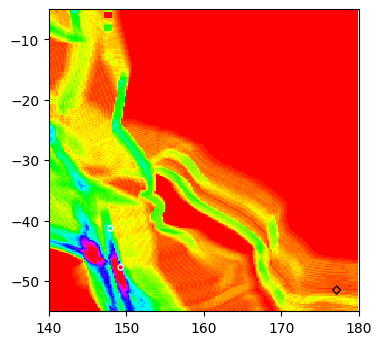

60.0


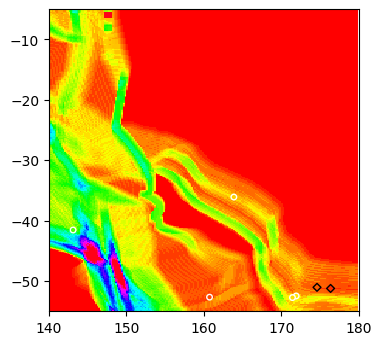

64.0


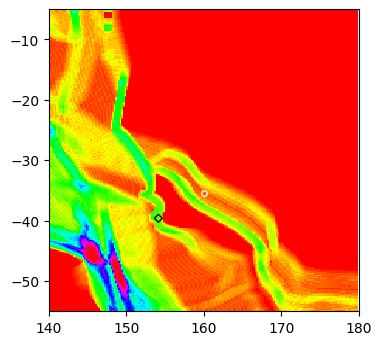

65.0


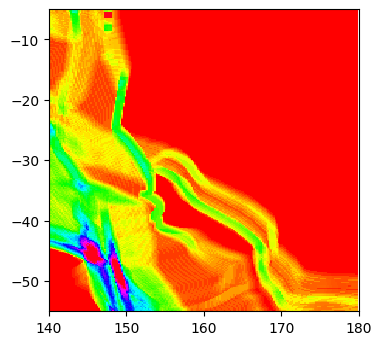

67.0


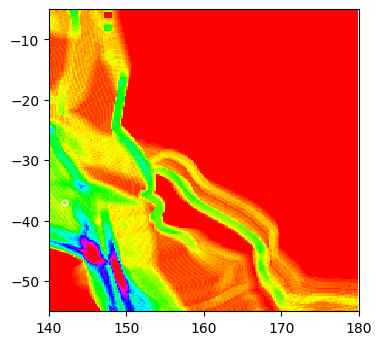

68.0


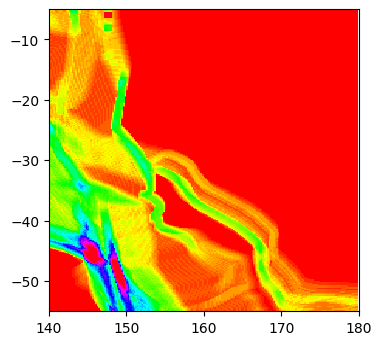

69.0


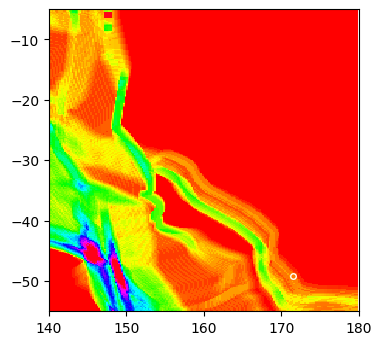

71.0


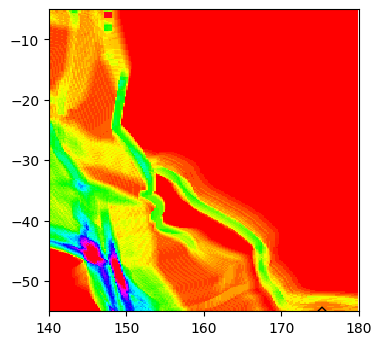

72.0


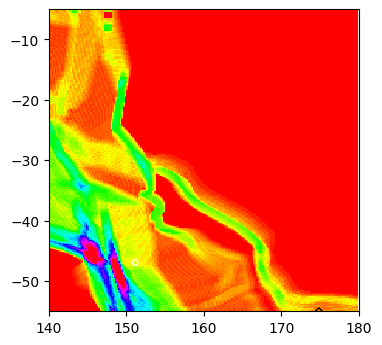

73.0


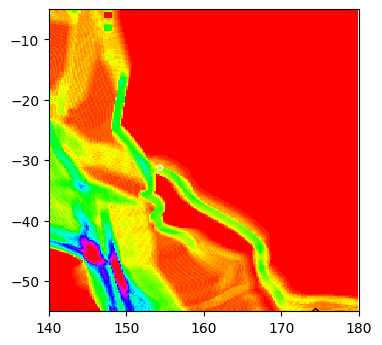

74.0


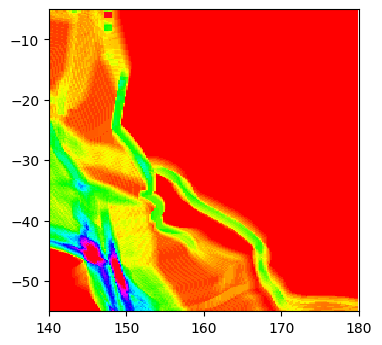

75.0


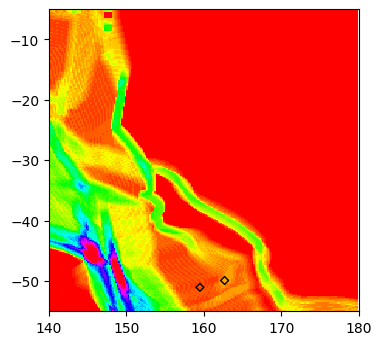

76.0


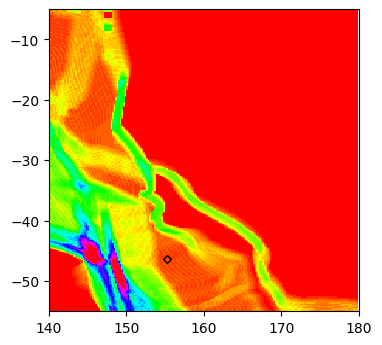

77.0


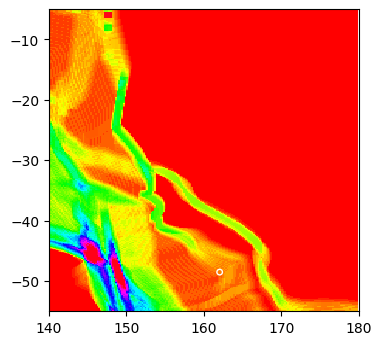

78.0


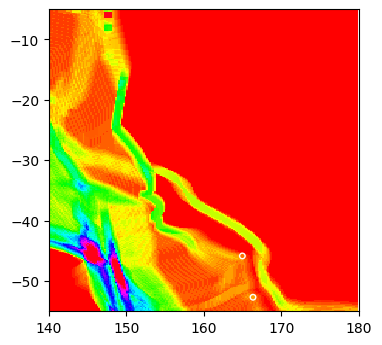

79.0


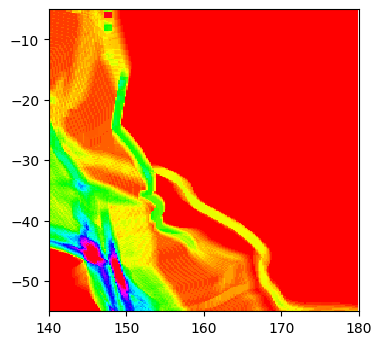

80.0


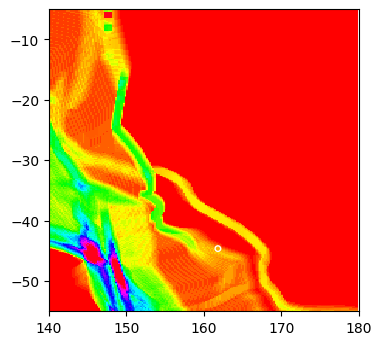

81.0


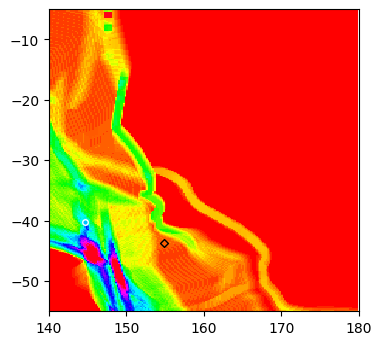

82.0


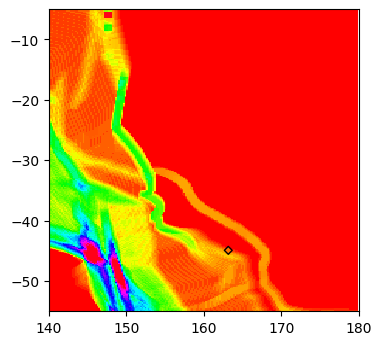

83.0


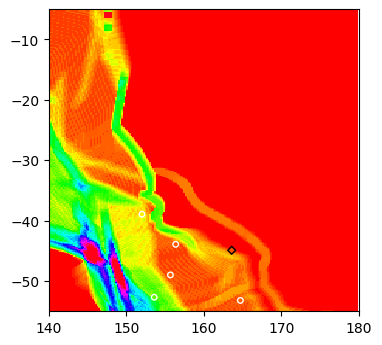

84.0


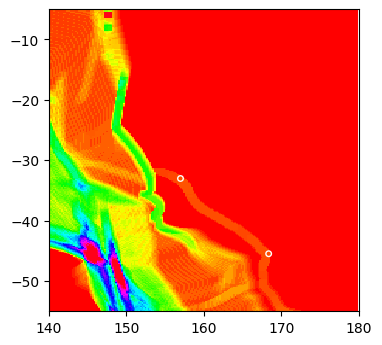

85.0


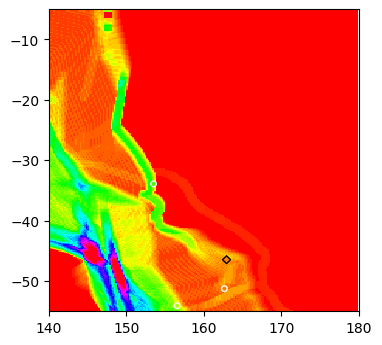

86.0


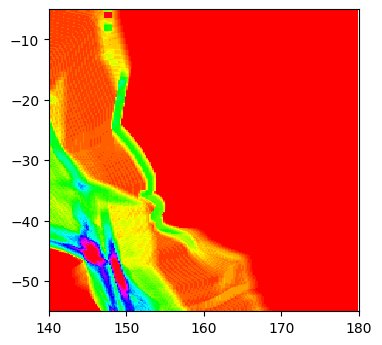

87.0


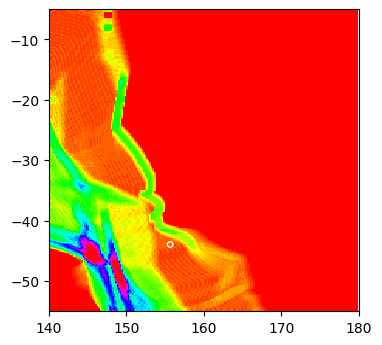

88.0


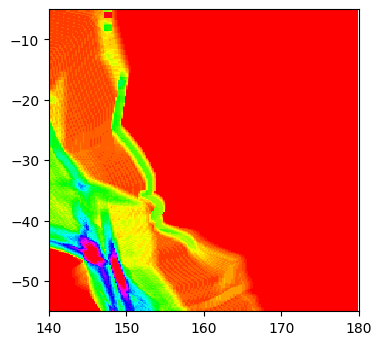

89.0


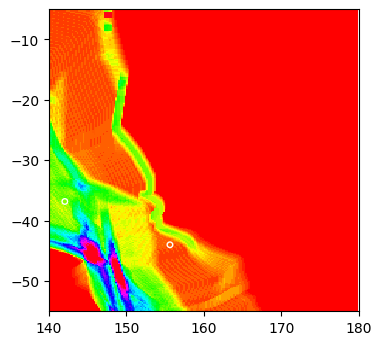

90.0


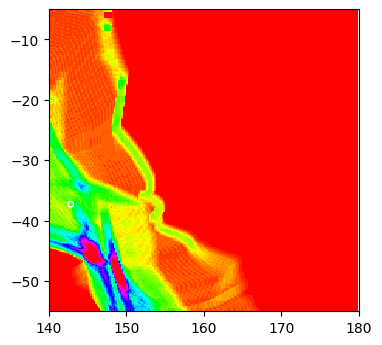

91.0


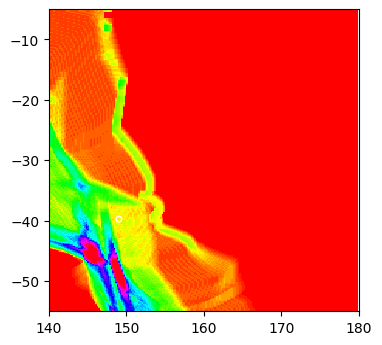

92.0


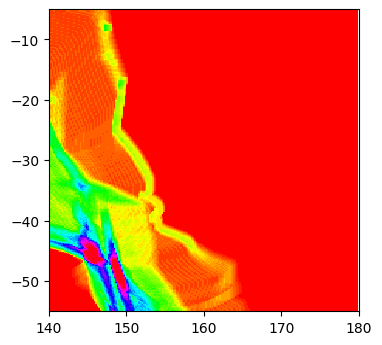

93.0


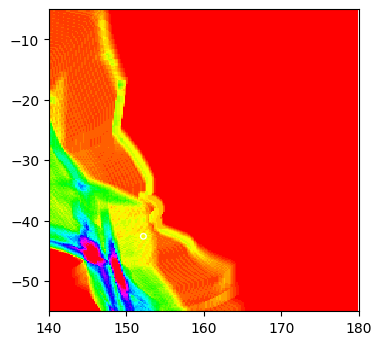

94.0


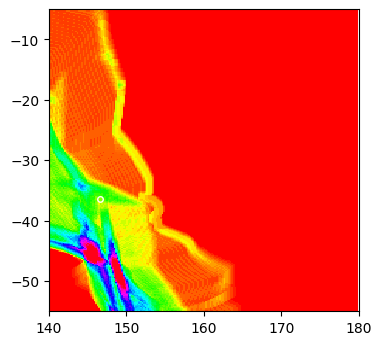

95.0


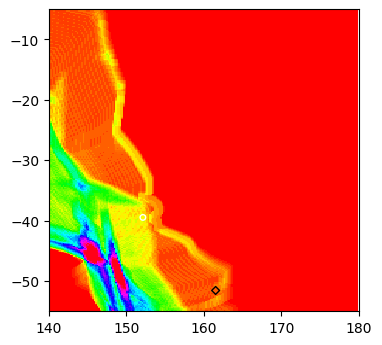

96.0


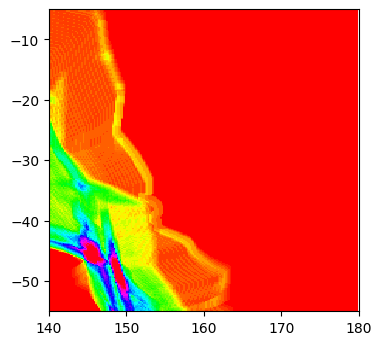

97.0


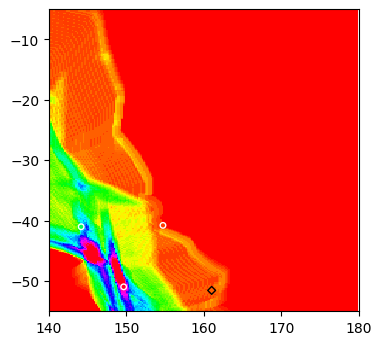

98.0


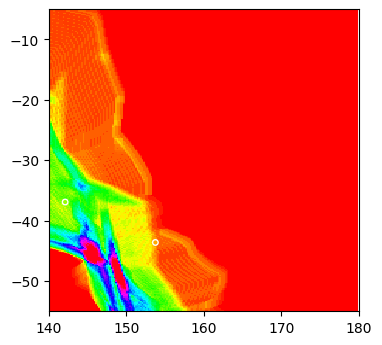

99.0


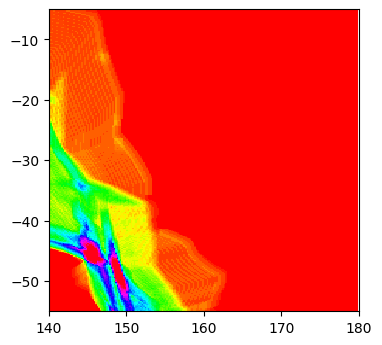

100.0


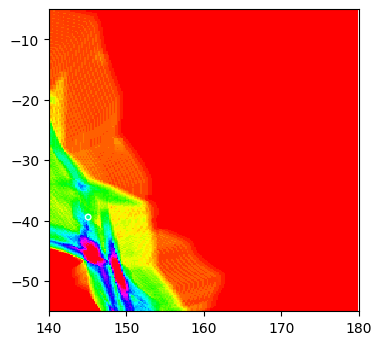

101.0


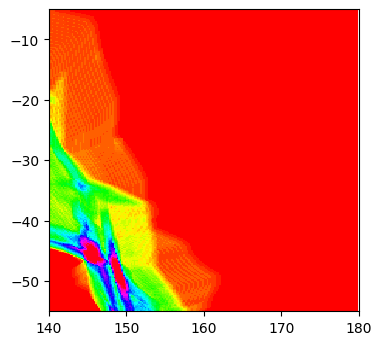

102.0


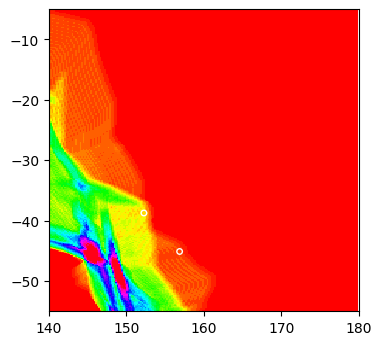

103.0


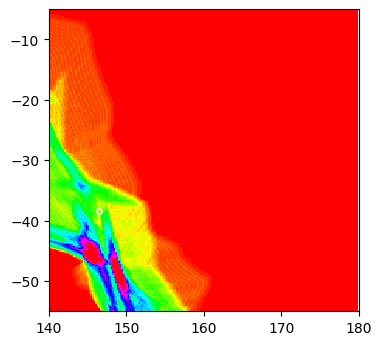

104.0


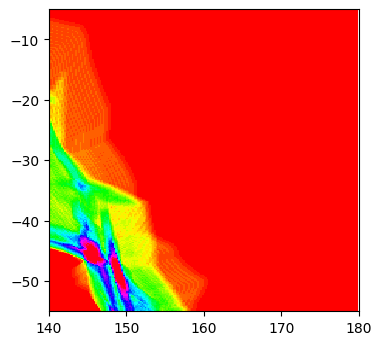

105.0


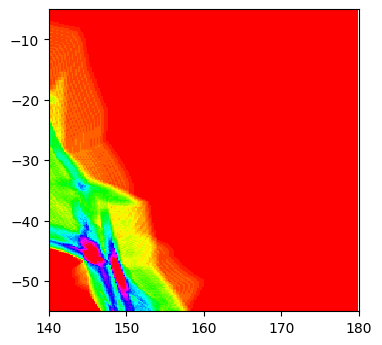

108.0


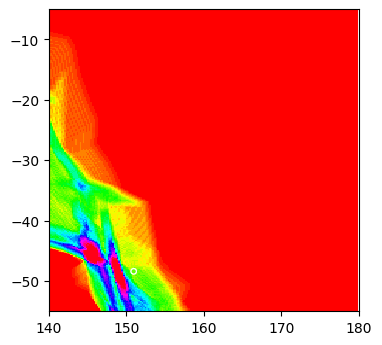

109.0


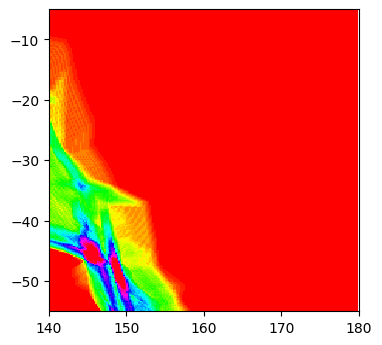

110.0


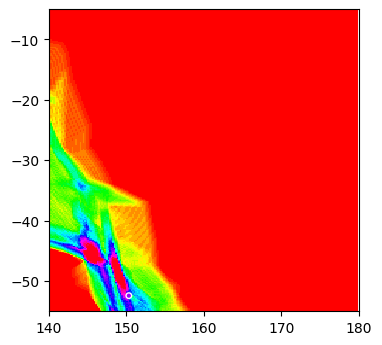

111.0


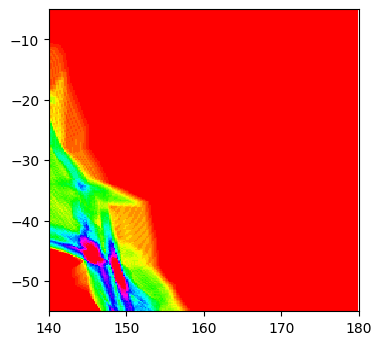

113.0


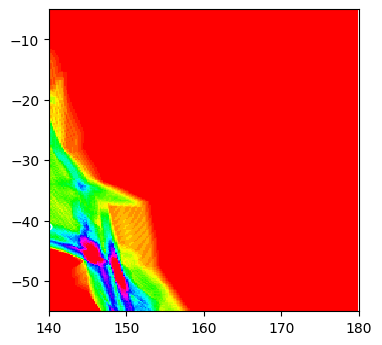

114.0


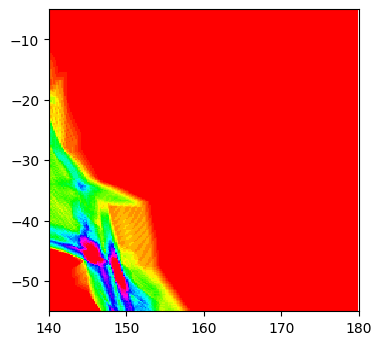

115.0


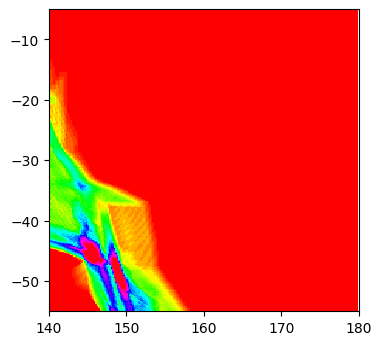

117.0


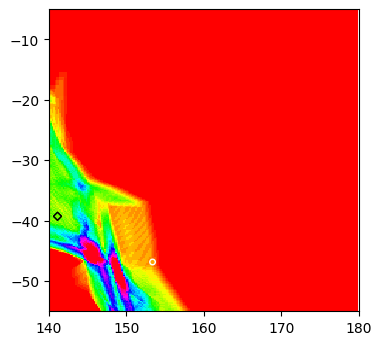

119.0


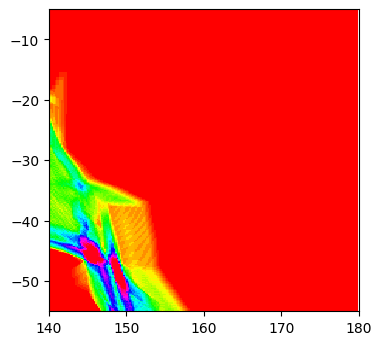

123.0


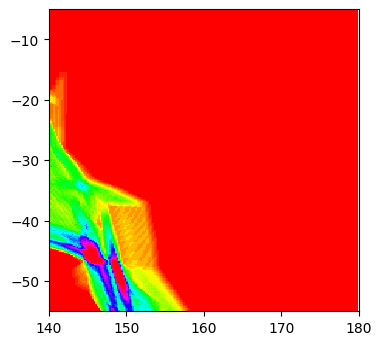

125.0


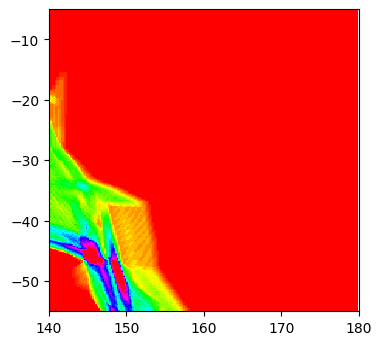

127.0


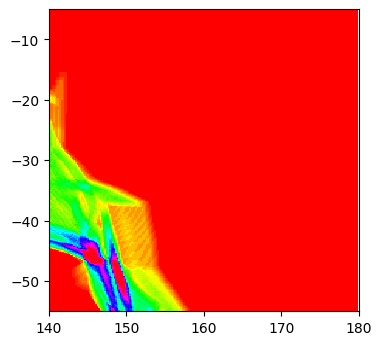

128.0


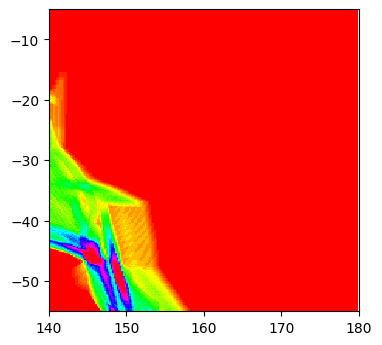

142.0


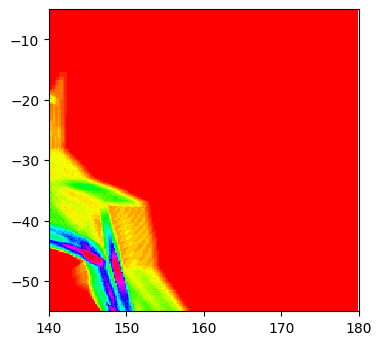

145.0


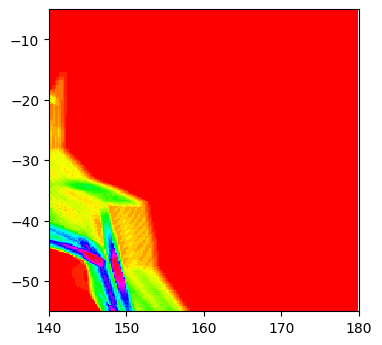

151.0


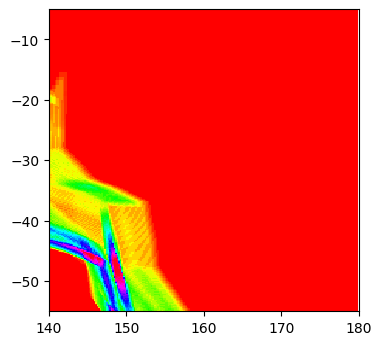

161.0


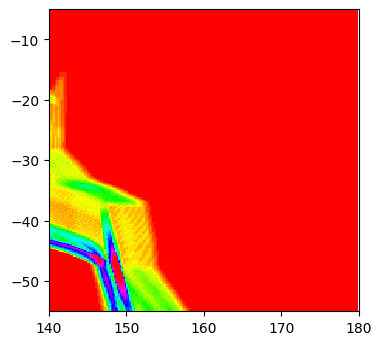

170.0


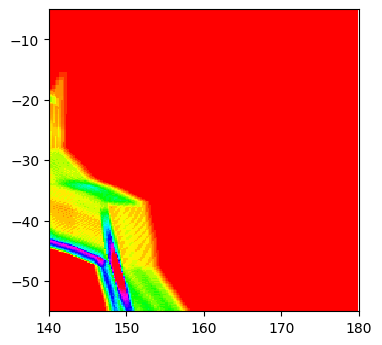

173.0


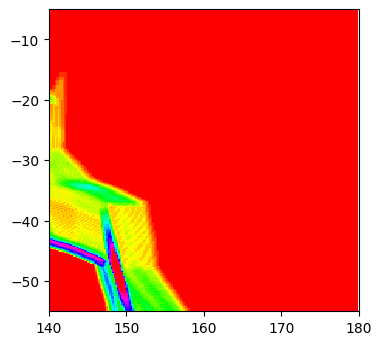

190.0


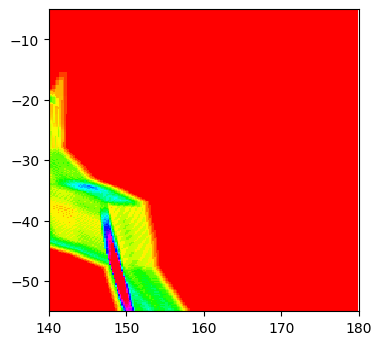

196.0


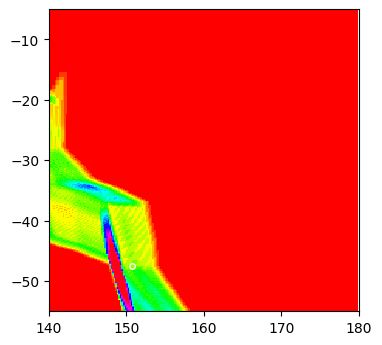

241.0


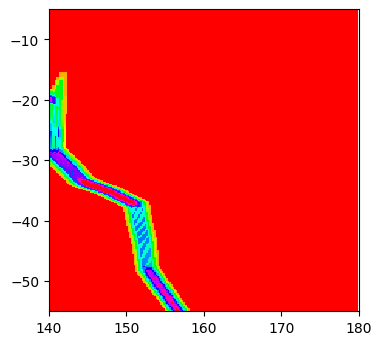

In [82]:
dfs=[]
for name, grp in groups:
    #print(name)
    #Grids only exist up to 250Ma
    if (name < 251):
        print(name)
        grpneg=groupsneg.get_group(name)
        
        grid = read_netcdf_grid(subcarlith_filename.format(name))
        makeplot(grid,grp,'gridsublith',grpneg)


In [80]:
def makeplot(grid,dataframe,val,neg):
    lats=np.arange(-90,90,(90+90)/np.shape(grid.data)[0])
    lons=np.arange(-180,180,(180+180)/np.shape(grid.data)[1])
    
    fig = plt.figure(figsize=(4, 4),dpi=100)
    
    #vvmax=np.nanmax(grid.data)
    #vvmin=np.nanmin(grid.data)
    vvmax=np.percentile(grid.data,99.5)
    vvmin=np.percentile(grid.data,0.5)
    
    mapdat=plt.pcolormesh(lons,lats,grid.data, 
              cmap=plt.cm.hsv,vmax=vvmax,vmin=vvmin)
    
        
    mapxneg = plt.scatter(neg.ReconLon, neg.ReconLat, c=neg[val],
                       edgecolors='white',vmin=vvmin,vmax=vvmax,cmap=plt.cm.hsv,marker='o')
    
    mapx = plt.scatter(dataframe.ReconLon, dataframe.ReconLat, c=dataframe[val],
                       edgecolors='black',vmin=vvmin,vmax=vvmax,cmap=plt.cm.hsv)

    plt.xlim([140,180])
    plt.ylim([-55,-5])
    plt.clim([vvmin,vvmax])
    plt.show()